# Walkthrough of PV Capacity Inference

The process of going from a Base GD file, to inference of the PV system capacity installed by each consumer, is an involved process.

The code for this is divided into two main folders, functions/ and data/.

## Functions

### retreive_nsrdb_data.jl

This file begins with getting filenames for files where I’ve locally saved some datasets of the “solar year” data as well as the coordinates where they were obtained.

The averaged MC Solar output function tries to get those preexisting files, and averages all of the solar years with a strict equal weighting, in order to get an “average solar year”. If the files aren’t there, it will call the next function, to make the NSRDB+SAM calls.

This next function calls out to NSRDB+SAM to obtain Monte Carlo dataset of solar years, and is the bulk of the logic in this file. It starts with an option to try and read from a cache, for testing purposes. It loads GIS files for population by district (to weight the sampling), the CNFL area (for CNFL vs ICE split), the protected areas (to exclude), and the overall map of Costa Rica (to make sure that points selected are only within the landmass of the country.) Reading in all these layers, it makes sure to do a projection from its current coordinate system to Lat, Lon. Since we have a shapefile with shapes for each district in the nation, as well as one specifically for CNFL, we use one or the other for selecting points for sampling. We create a weights vector for the sampling, and loop until we have the desired number of coordinates, using the weights each time to sample from the indices. We then go through to ensure that the potential sample location is:
- a new coordinate
- actually over land and not ocean
- either in CNFL or ICE (if that’s a parameter)
- not within any of the protected areas

Once that has been confirmed, we try calling out to NSRDB + SAM. This will return the outputs of SAM, along with a DataFrame of all of the coordinates for future reference. It does so via a wrapper to call get_nsrdb_sam_df, or if we want to skip all this and just return a hardcoded value (historical code, for testing purposes).
The wrapper function obtains the NSRDB request URL from yet another function, and makes a call to the python function which actually calling to the NREL services.
The NSRDB request URL constructor function requires an external file with credentials, and uses it as well as other parameters to construct a string.

### nsrdb_python.py

This file contains the function which calls to NSRDB and uses the PySAM module. It begins with one line to call to NSRDB (which has a sleep because it previously had many issues of timeouts/overlapping queries/hitting hourly limits). It creates a PySSC object containing the atmospheric data, and a wrapper PySSC object with the atmospheric data object as well as the PV system configurations. It executes the PvWattsV5 module with this data, to obtain and return the “Generation” column of the result.

There is also a function to plot coordinates, since doing so in Julia was excruciatingly difficult. It uses GeoDataFrames to plot the map alongside the coordinates. This is demonstrated at the end of this notebook.

### plotting_base_gd

This file is used heavily throughout the Base_GD_data_analysis notebooks.

This file starts with some categorical data of types of tariffs, as well as how they can be grouped. 

It then obtains the PV output, from our NSRDB + SAM pipeline above, which will be used for all installation and modeling calculations. This PV output is adjusted with the assumption of 70% efficiency, and used to obtain monthly totals for each month of the year.

The first function takes the utility bill DF and
- Removes incomplete rows
- Removes nonsense rows of < 100kWh per month, which would only come from a 1kW or lower capacity system. This is a value which is deemed irrelevant to our analysis, due to being too small
- Estimates what installation is, given that monthly output of a 1kW system. This is done by dividing the known generation of the system from the known month, with the previously obtained monthly energy total of that month.

It then discards any estimate less than 1kW, and returns the rest.

The next function plots consumption versus installation, using data from the function above. 
Then there's a function for plotting the estimated “true” data versus the “economically rational” model. It plots the data, then if desired, plots a linear regression of that data. It can then plot the model prediction (or multiple models). 
There follow a function for plotting all tariffs of a single tariff category, with a model prediction.
Then a function plotting each tariff of a single category individually.
A function plots a full tariff category with two regressions, divided at a pivot point.
Then there's a function plotting a full tariff category with multiple regressions. This needs to be a separate function from the one above because otherwise, it’s difficult to formulate the limits for the plotting/regression/etc.
There's a function to plot with a separate linear regression for each tariff within a tariff category. In contrast to an earlier function dealing with multiple regressions by consumption amount, this one is of regressions by label. It also includes standard error (standard deviation) bars on the line of best fit through the data.
Finally, there is a function to plot a whole tariff category (rate group), each subtariff being a different color. It is done with a full regression, optionally with per-tariff regressions, and optionally with a regression of data <= some limit.

## Data

The `data/` folder contains miscellaneous data central to the analysis, much of it generated by the functions enumerated above. Some highlights:
- `area_CNFL` is the GIS file of CNFL area
- `Areaprotegidas` is the GIS file of protected areas
- `distritos` is the GIS file of districts of costa rica and their population, which is used to calculate weights.
- `monte_carlo_data/` is a folder containing solar year PV output and coordinates for each value
    - `CNFL_100`
    - `CNFL_100_COORDS`
    - `ICE_100`
    - `ICE_100_COORDS`
- In `consumer_data.jl`, we made different consumer objects for CNFL and ICE, with no difference in numbers, just in tariff scheme.
- `nsrdb_sam_data_file.txt` is simply one sample output of a run through NSRDB and SAM
- In `pvsystem_data.jl`, we altered it to obtain solar year PV output from this new pipeline. We also defined PV systems that operate on that particular calendar year, as opposed to previously just using a single file

## Plotting the geographic locations sampled for these analyses

As part of the Monte Carlo analysis, we sampled many different locations across Costa Rica, and got a solar year of data at each one. In order to understand our sample and its distribution geographically, here we display a map of the various locations selected when constructing the typical solar year for CNFL and ICE, respectively.

In [1]:
using PyCall
using PyPlot
py"""
import sys
sys.path.insert(0, "./functions")
"""
plot_mc_coords_py = pyimport("nsrdb_python")["plot_mc_coords"];
println(plot_mc_coords_py)

┌ Info: Recompiling stale cache file /Users/arnavgautam/.julia/compiled/v1.1/PyCall/GkzkC.ji for PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/arnavgautam/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[1]:7
└ @ Core In[1]:7


PyObject <function plot_mc_coords at 0x12bc83488>


### Map for CNFL

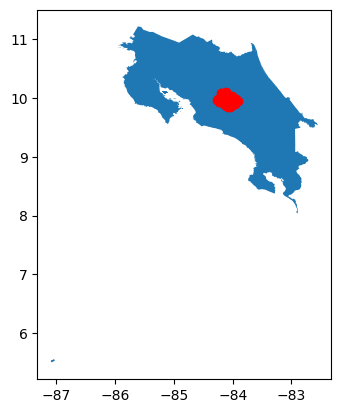

In [2]:
plot_mc_coords_py("data/monte_carlo_data/CNFL_100_COORDS.txt")

###  Map for CNFL, zoomed in

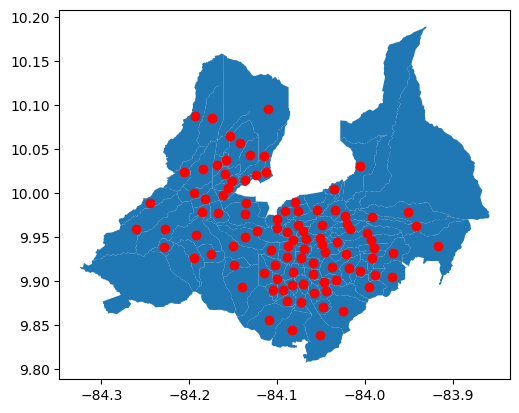

In [3]:
plot_mc_coords_py("data/monte_carlo_data/CNFL_100_COORDS.txt",cnfl=true)

### Map for ICE

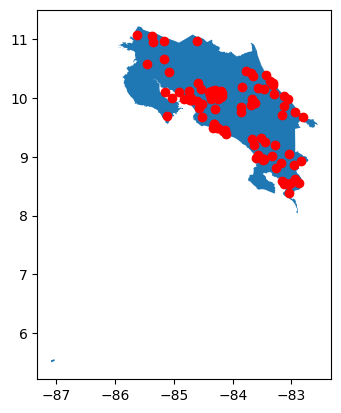

In [4]:
plot_mc_coords_py("data/monte_carlo_data/ICE_100_COORDS.txt");

## Histograms of the data distributions for CNFL and ICE "solar year" totals

We also want to understand the distribution of the energy that shines on all of the locations, since these are all averaged out to create the final timeseries used for analysis.

In [1]:
include("functions/retrieve_nsrdb_data.jl")

plot_pysam_output (generic function with 3 methods)

### CNFL energy distribution

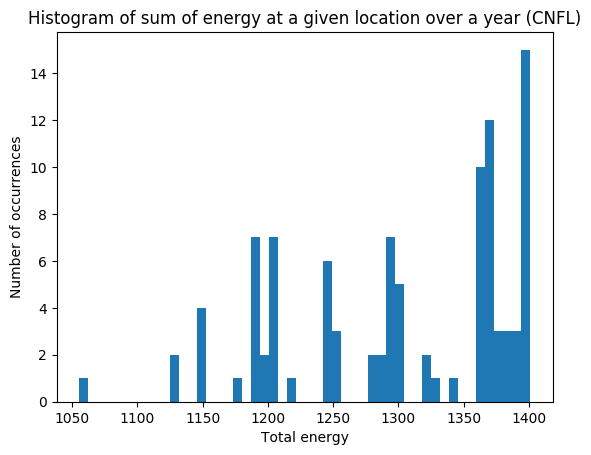

PyObject Text(24.00000000000002, 0.5, 'Number of occurrences')

In [3]:
cnfl_100, cnfl_coords = monte_carlo_solar_output(100, [true]; use_cached=true)
total_energies = vec(sum(cnfl_100, dims=(1)))
hist(total_energies, bins=50)
title("Histogram of sum of energy at a given location over a year (CNFL)")
xlabel("Total energy")
ylabel("Number of occurrences")

### ICE energy distribution

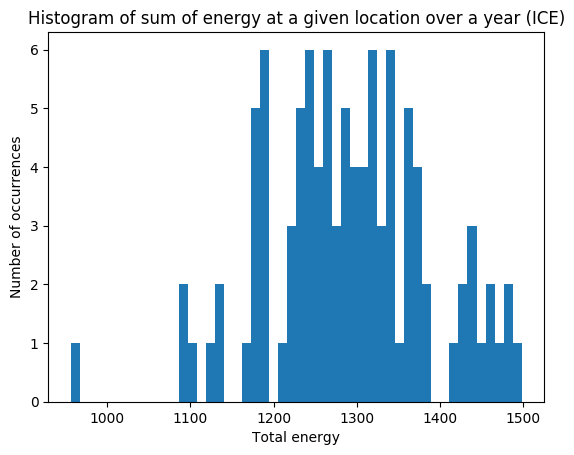

PyObject Text(24.00000000000002, 0.5, 'Number of occurrences')

In [2]:
ice_100, ice_coords = monte_carlo_solar_output(100, [false]; use_cached=true)
total_energies = vec(sum(ice_100, dims=(1)))
hist(total_energies, bins=50)
title("Histogram of sum of energy at a given location over a year (ICE)")
xlabel("Total energy")
ylabel("Number of occurrences")